In [1]:
import torch
import time
import datetime
import os
import argparse
import pickle 
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import random
import sys
sys.path.append(os.path.abspath('..'))
from models import *

import matplotlib.pyplot as plt
import ast
import matplotlib.tri as tri
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [2]:
PATH="train/P2_CNN2D_test"
num_gpu='1'

In [3]:
gpu_id=str(num_gpu)
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  1


In [4]:
gparams = {}
with open(os.path.join(PATH, "parameters.txt"), "r") as f:
    for line in f:
        key, value = line.strip().split(":")  
        if value.isdigit():  
            gparams[key] = int(value)
        else:
            try:
                gparams[key] = ast.literal_eval(value)
            except (ValueError, SyntaxError):
                gparams[key] = value

print(gparams)

{'name': 'test', 'seed': 0, 'use_squeue': False, 'gpu': 1, 'type': 'circlehole', 'num_train_data': 1000, 'num_validate_data': 1000, 'basis_order': 2, 'ne': 555, 'model': 'CNN2D', 'batch_size': None, 'resol_in': 20, 'blocks': 4, 'ks': 5, 'filters': 32, 'act': 'silu', 'epochs': 50000, 'do_precond': False}


In [5]:
NAME=gparams['name']
TYPE = gparams['type']
NUM_TRAIN_DATA = gparams['num_train_data']
NUM_VALIDATE_DATA = gparams['num_validate_data']
BASIS_ORDER = gparams['basis_order']
NUM_ELEMENT = gparams['ne']

mesh=np.load(f'mesh/P{BASIS_ORDER}_ne{NUM_ELEMENT}_{TYPE}.npz')
_, NUM_PTS, p, c = mesh['ne'], mesh['ng'], mesh['p'], mesh['c']
NUM_BASIS = NUM_PTS

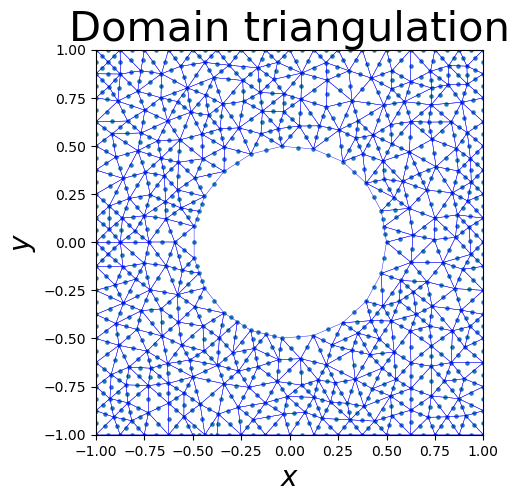

In [6]:
fig=plt.figure(figsize=(5,5))
plt.title("Domain triangulation", fontsize=30)
plt.scatter(p[:,0],p[:,1], s=5)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
for i in range(len(c)):
    plt.plot(p[c[i][0:3]][:,0],p[c[i][0:3]][:,1],c='b', linewidth=0.3)
    plt.plot(np.array([p[c[i][2]],p[c[i][0]]])[:,0],np.array([p[c[i][2]],p[c[i][0]]])[:,1],c='b', linewidth=0.3)

In [7]:
models = {
          'CNN1D': CNN1D,
          'CNN2D': CNN2D,
          }
MODEL = models[gparams['model']]
BLOCKS = int(gparams['blocks'])
KERNEL_SIZE = int(gparams['ks'])
FILTERS = int(gparams['filters'])
PADDING = (KERNEL_SIZE - 1)//2
ACT = gparams['act']
if gparams['model']=='CNN2D':
    RESOL_IN=gparams['resol_in']
D_in = 1
D_out = NUM_BASIS

In [8]:
class Dataset(Dataset):
    def __init__(self, mesh, kind='train', num_train=False):
        self.kind=kind
        self.num_train=num_train
        pickle_file_load = f'{self.kind}_P{BASIS_ORDER}_{NUM_TRAIN_DATA}N{NUM_ELEMENT}_{TYPE}'
        with open(f'data/{pickle_file_load}.pkl', 'rb') as f:
            self.data = pickle.load(f)
        self.load_vector = mesh[f'{kind}_load_vectors']
    def __getitem__(self, idx):
        coeff_u = torch.FloatTensor(self.data[idx,0]).unsqueeze(0)
        f_value = torch.FloatTensor(self.data[idx,1]).unsqueeze(0)
        coeff_f = torch.FloatTensor(self.data[idx,2])
        load_vec_f = torch.FloatTensor(self.load_vector[idx])
        return {'coeff_u': coeff_u, 'f_value': f_value, 'coeff_f': coeff_f, 'load_vec_f' : load_vec_f}

    def __len__(self):
        if self.kind=='train':
            return self.num_train
        else:
            return len(self.data)

lg_dataset = Dataset(mesh, kind='train', num_train=NUM_TRAIN_DATA)
trainloader = DataLoader(lg_dataset, batch_size=NUM_TRAIN_DATA, shuffle=False)
lg_dataset = Dataset(mesh, kind='validate')
validateloader = DataLoader(lg_dataset, batch_size=NUM_VALIDATE_DATA, shuffle=False)

print("Num train : {}, Num test: {}".format(len(trainloader.dataset), len(validateloader.dataset)))

Num train : 1000, Num test: 1000


In [9]:
if gparams['model']=='CNN2D':
    model = MODEL(ACT, RESOL_IN, D_in, FILTERS, D_out, kernel_size=KERNEL_SIZE, padding=PADDING, blocks=BLOCKS)
else:
    model = MODEL(ACT, D_in, FILTERS, D_out, kernel_size=KERNEL_SIZE, padding=PADDING, blocks=BLOCKS)

model.cuda()
load_model = torch.load(os.path.join(PATH, "model.pt"))
model.load_state_dict(load_model['model_state_dict'])

<All keys matched successfully>

In [10]:
for validate_data in validateloader:
    coeff_u = validate_data['coeff_u']
    coeff_f = validate_data['coeff_f']
    data_f = validate_data['f_value']

In [11]:
PATH_precond="train/P2_CNN2D_test_precond"

if gparams['model']=='CNN2D':
    model_precond = MODEL(ACT, RESOL_IN, D_in, FILTERS, D_out, kernel_size=KERNEL_SIZE, padding=PADDING, blocks=BLOCKS)
else:
    model_precond = MODEL(ACT, D_in, FILTERS, D_out, kernel_size=KERNEL_SIZE, padding=PADDING, blocks=BLOCKS)


PRECOND=mesh['precond']
PRECOND = torch.tensor(PRECOND).cuda().float()
model_precond.cuda()
load_model = torch.load(os.path.join(PATH_precond, "model.pt"))
model_precond.load_state_dict(load_model['model_state_dict'])

<All keys matched successfully>

In [12]:
def f(x,y,coeff):
    m0, m1, n0, n1, n2, n3=coeff[:,[0]], coeff[:,[1]], coeff[:,[2]], coeff[:,[3]], coeff[:,[4]], coeff[:,[5]]
    return m0*torch.sin(n0*x+n1*y) + m1*torch.cos(n2*x+n3*y)

In [13]:
grid_x=torch.linspace(-1,1,RESOL_IN)
input_grid=torch.cartesian_prod(grid_x,grid_x).cuda()

In [14]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, axis=-1)/torch.sum((true)**2, axis=-1))**0.5

820


/tmp/ipykernel_25641/206728755.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(name='terrain')


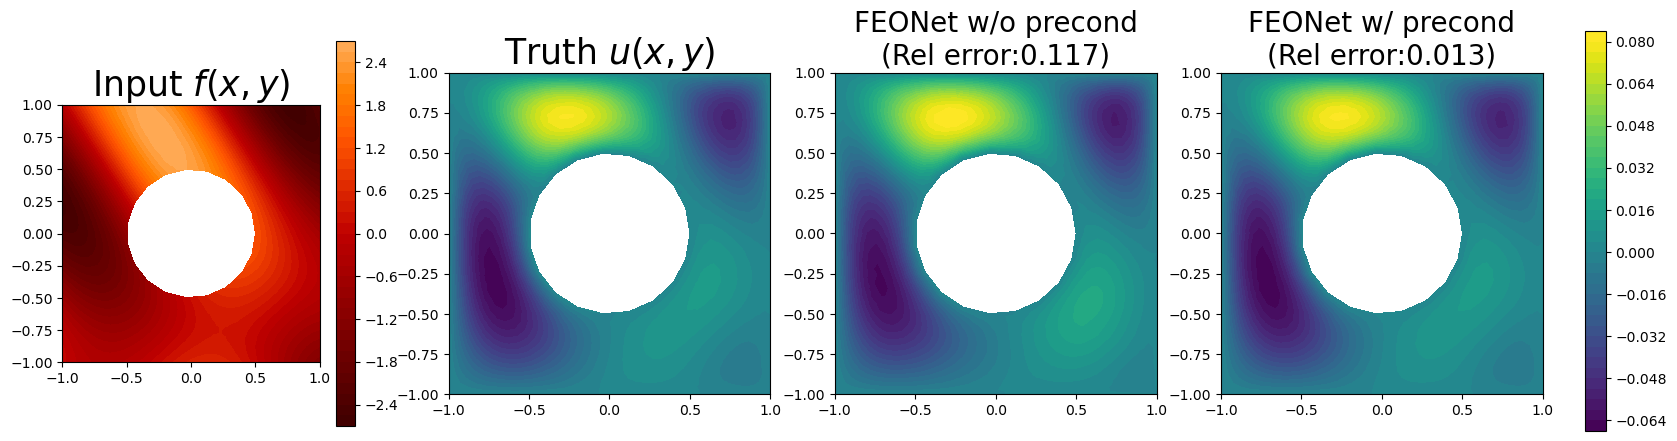

In [15]:
## For circlehole
plot_idx=np.random.randint(len(trainloader.dataset))
print(plot_idx)
x=p[:,0]
y=p[:,1]
_data_f = data_f[[plot_idx]].cuda()
_coeff_f = coeff_f[[plot_idx]].cuda()
_coeff_u = coeff_u[[plot_idx]].cuda()
value_f=f(input_grid[:,0],input_grid[:,1], _coeff_f).reshape(-1,1,RESOL_IN,RESOL_IN)

output_u_original=model(value_f)

output_u_precondition=model_precond(value_f)
output_u_precondition=(PRECOND@output_u_precondition.transpose(1,2)).transpose(1,2)

mini, maxi = min(_coeff_u[0][0]), max(_coeff_u[0][0])

triang = tri.Triangulation(x, y)
min_radius = 0.5
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)
cmap = cm.get_cmap(name='terrain')


fig=plt.figure(figsize=(21,5), dpi=100)
ax=plt.subplot(1,4,1)
ax.set_title(r'Input $f(x,y)$',fontsize=25)
im=ax.tricontourf(triang, _data_f[0][0].cpu(), vmin=-4, vmax=4, cmap="gist_heat", levels=40)
ax.set_aspect(1)
#cbar_ax = plt.subplot(1,4,2)
#fig.colorbar(im, cax=cbar_ax)
fig.colorbar(im)
             
ax=plt.subplot(1,4,2)
ax.set_title(r'Truth $u(x,y)$',fontsize=25)
im=ax.tricontourf(triang, _coeff_u[0][0].cpu(), vmin=mini, vmax=maxi, cmap="viridis", levels=40)
ax.set_aspect(1)

ax=plt.subplot(1,4,3)
error_original=rel_L2_error(output_u_original[0][0].detach().cpu(),_coeff_u[0][0].cpu())
ax.set_title('FEONet w/o precond\n(Rel error:{:.3f})'.format(error_original),fontsize=20)
im=ax.tricontourf(triang, output_u_original[0][0].detach().cpu(), vmin=mini, vmax=maxi, cmap="viridis", levels=40)
ax.set_aspect(1)

ax=plt.subplot(1,4,4)
error_precondition=rel_L2_error(output_u_precondition[0][0].detach().cpu(),_coeff_u[0][0].cpu())
ax.set_title('FEONet w/ precond\n(Rel error:{:.3f})'.format(error_precondition),fontsize=20)
im=ax.tricontourf(triang, output_u_precondition[0][0].detach().cpu(), vmin=mini, vmax=maxi, cmap="viridis", levels=40)
ax.set_aspect(1)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.10, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)